In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC
import econml
import importlib
import pyreadr

import tqdm

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        # "mar": "Married",
        # "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

(1271, 11)


Impute Y(t) \
Model P(Y(1),Y(0),X) using KDE \
Logistic regression to model P(S=1 | X), \
Logistic regression to model P(T=1 | X, S=1) \
P( Y=1 | T, X, S=1 ): Option 1 - Logistic Regression

In [11]:
np.random.seed(42)
y1_m = en.GradientBoostingClassifier(n_estimators=10000).fit(
    X.loc[(S == 1) * (T == 1)], Y.loc[(S == 1) * (T == 1)]
)
y0_m = en.GradientBoostingClassifier(n_estimators=10000).fit(
    X.loc[(S == 1) * (T == 0)], Y.loc[(S == 1) * (T == 0)]
)

In [70]:
# np.random.seed(42)
# joint = X.copy(deep=True)
# joint["Y(1)"] = np.random.binomial(1, y1_m.predict_proba(X)[:, 1])
# joint["Y(0)"] = np.random.binomial(1, y0_m.predict_proba(X)[:, 1])
# [
#     Y.loc[i]
#     if (T.loc[i] == 1 and S.loc[i] == 1)
#     else np.random.binomial(1, y1_m.predict_proba(X.loc[[i]])[0, 1])
#     for i in tqdm.tqdm(Y.index)
# ]
# joint["Y(0)"] = [
#     Y.loc[i]
#     if (T.loc[i] == 0 and S.loc[i] == 1)
#     else np.random.binomial(1, y0_m.predict_proba(X.loc[[i]])[0, 1])
#     for i in tqdm.tqdm(Y.index)
# ]

In [74]:
# joint = pd.read_csv("synth_train_joint.csv", index_col=0)
# P(X,Y(1),Y(0))
# px = KernelDensity(kernel="gaussian", bandwidth=0.15).fit(X)

# P(S=1 | X)
pi_m = lm.LogisticRegressionCV().fit(X, S)
# P(T=1 | X, S=1)
e_m = lm.LogisticRegressionCV().fit(X.loc[S == 1], T.loc[S == 1])

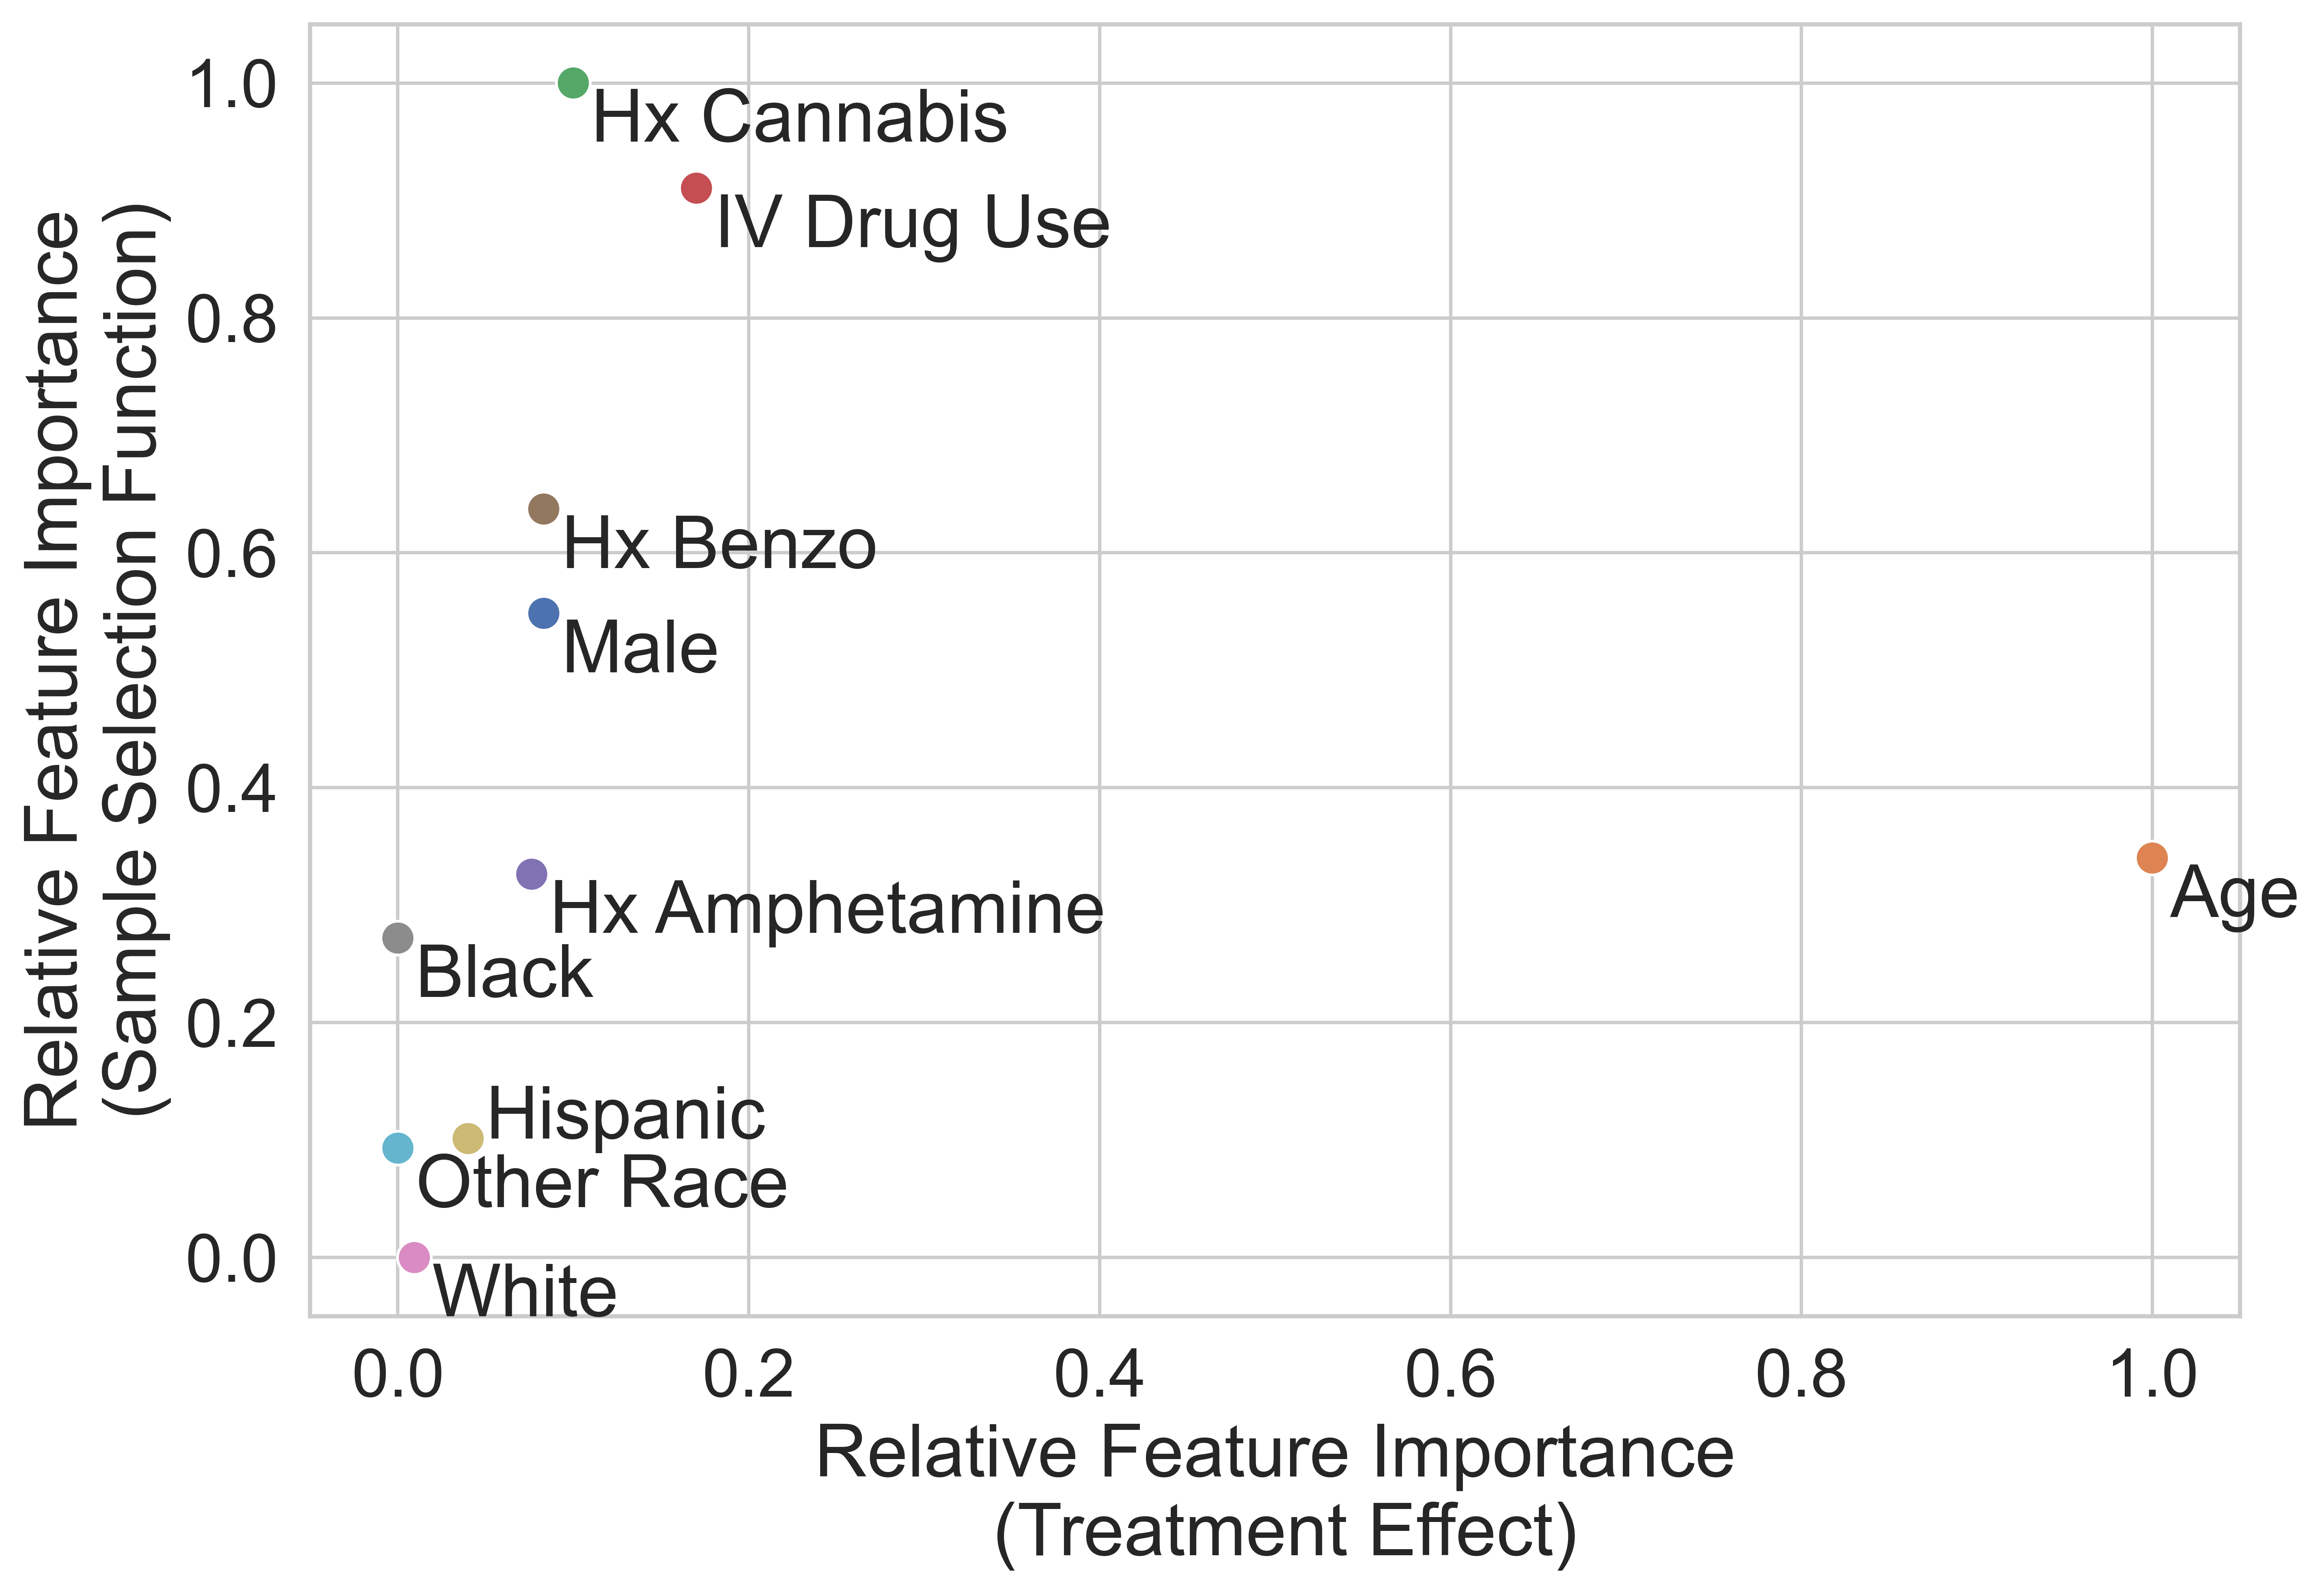

In [67]:
feature_imp = pd.DataFrame()
feature_imp["treatment effect"] = pd.Series(
    y1_m.feature_importances_ + y0_m.feature_importances_, index=X.columns
).abs()
feature_imp["sample"] = pd.Series(pi_m.coef_[0], index=X.columns).abs()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_imp_scaled = pd.DataFrame(
    scaler.fit_transform(feature_imp),
    columns=feature_imp.columns,
    index=feature_imp.index,
)


def label_point(data, x, y, val, ax):
    for i in data.index:
        if "Hispanic" in str(data.loc[i][val]):
            ax.text(data.loc[i][x] + 0.01, data.loc[i][y], str(data.loc[i][val]))
        else:
            ax.text(data.loc[i][x] + 0.01, data.loc[i][y] - 0.05, str(data.loc[i][val]))


fig, ax = plt.subplots(figsize=(10, 7), dpi=600)
sns.scatterplot(
    data=feature_imp_scaled.reset_index(),
    x="treatment effect",
    y="sample",
    hue="index",
    ax=ax,
    s=100,
    legend=False,
)
label_point(
    data=feature_imp_scaled.reset_index(),
    x="treatment effect",
    y="sample",
    val="index",
    ax=ax,
)
plt.xlabel("Relative Feature Importance\n (Treatment Effect)")
plt.ylabel("Relative Feature Importance\n (Sample Selection Function)")
# plt.legend(ncols=3, loc=(0, -0.35))
plt.tight_layout()
plt.savefig("feature_importance_synth_case.pdf")

In [75]:
# X_sim = pd.DataFrame(
#     px.sample(n_samples=750000, random_state=42), columns=X.columns
# ).round(0)
# X_sim.describe()

In [76]:
X_sim = X.copy(deep=True)

# X_sim[discrete_col] = (X_sim[discrete_col] > 0.05).astype(int)

joint_sim = X_sim.copy(deep=True)
joint_sim["Y(1)"] = np.random.binomial(1, y1_m.predict_proba(X_sim)[:, 1])
joint_sim["Y(0)"] = np.random.binomial(1, y0_m.predict_proba(X_sim)[:, 1])

S_sim = np.random.binomial(1, pi_m.predict_proba(X_sim)[:, 1])
T_sim = np.random.binomial(1, e_m.predict_proba(X_sim)[:, 1])
Y_sim = T_sim * joint_sim["Y(1)"] + (1 - T_sim) * joint_sim["Y(0)"]

In [77]:
df_sim = X_sim.copy(deep=True)
df_sim["Y"] = Y_sim
df_sim["T"] = T_sim
df_sim["S"] = S_sim
df_sim.describe()

,Male,Age,Hx Cannabis,IV Drug Use,Hx Amphetamine,Hx Benzo,White,Black,Hispanic,Other Race,Y,T,S
count,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000,741286.000000
mean,0.584409,38.067975,0.114950,0.537925,0.066640,0.056263,0.654884,0.148597,0.141617,0.054902,0.697400,0.417189,0.001744
std,0.492824,12.132133,0.318962,0.498560,0.249397,0.230429,0.475407,0.355691,0.348658,0.227789,0.459384,0.493095,0.041728
min,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,47.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,68.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Analyses

In [78]:
data = df_sim
treatment = "T"
outcome = "Y"
sample = "S"

In [79]:
importlib.reload(learn)
df_v_est, pi_est, pi_m_est, e_m_est, data2_est = learn.estimate_dml(
    data, outcome, treatment, sample
)

In [90]:
print(
    "RCT-ATE: %.2f ± %.2f"
    % (
        100
        * (
            data.loc[(data[sample] == 1) * (data[treatment] == 1), outcome].mean()
            - data.loc[(data[sample] == 1) * (data[treatment] == 0), outcome].mean()
        ),
        100
        * (
            data.loc[(data[sample] == 1) * (data[treatment] == 1), outcome].sem()
            + data.loc[(data[sample] == 1) * (data[treatment] == 0), outcome].sem()
        ),
    )
)


print(
    "RCT-IPW ATE: %.2f ± %.2f" % (100 * df_v_est["a"].mean(), 100 * df_v_est["a"].sem())
)

print(
    "Transported ATE: %.2f ± %.2f"
    % (100 * df_v_est["te"].mean(), 100 * df_v_est["te"].sem())
)

RCT-ATE: -13.02 ± 3.66
RCT-IPW ATE: -13.07 ± 4.62
Transported ATE: -12.72 ± 4.66


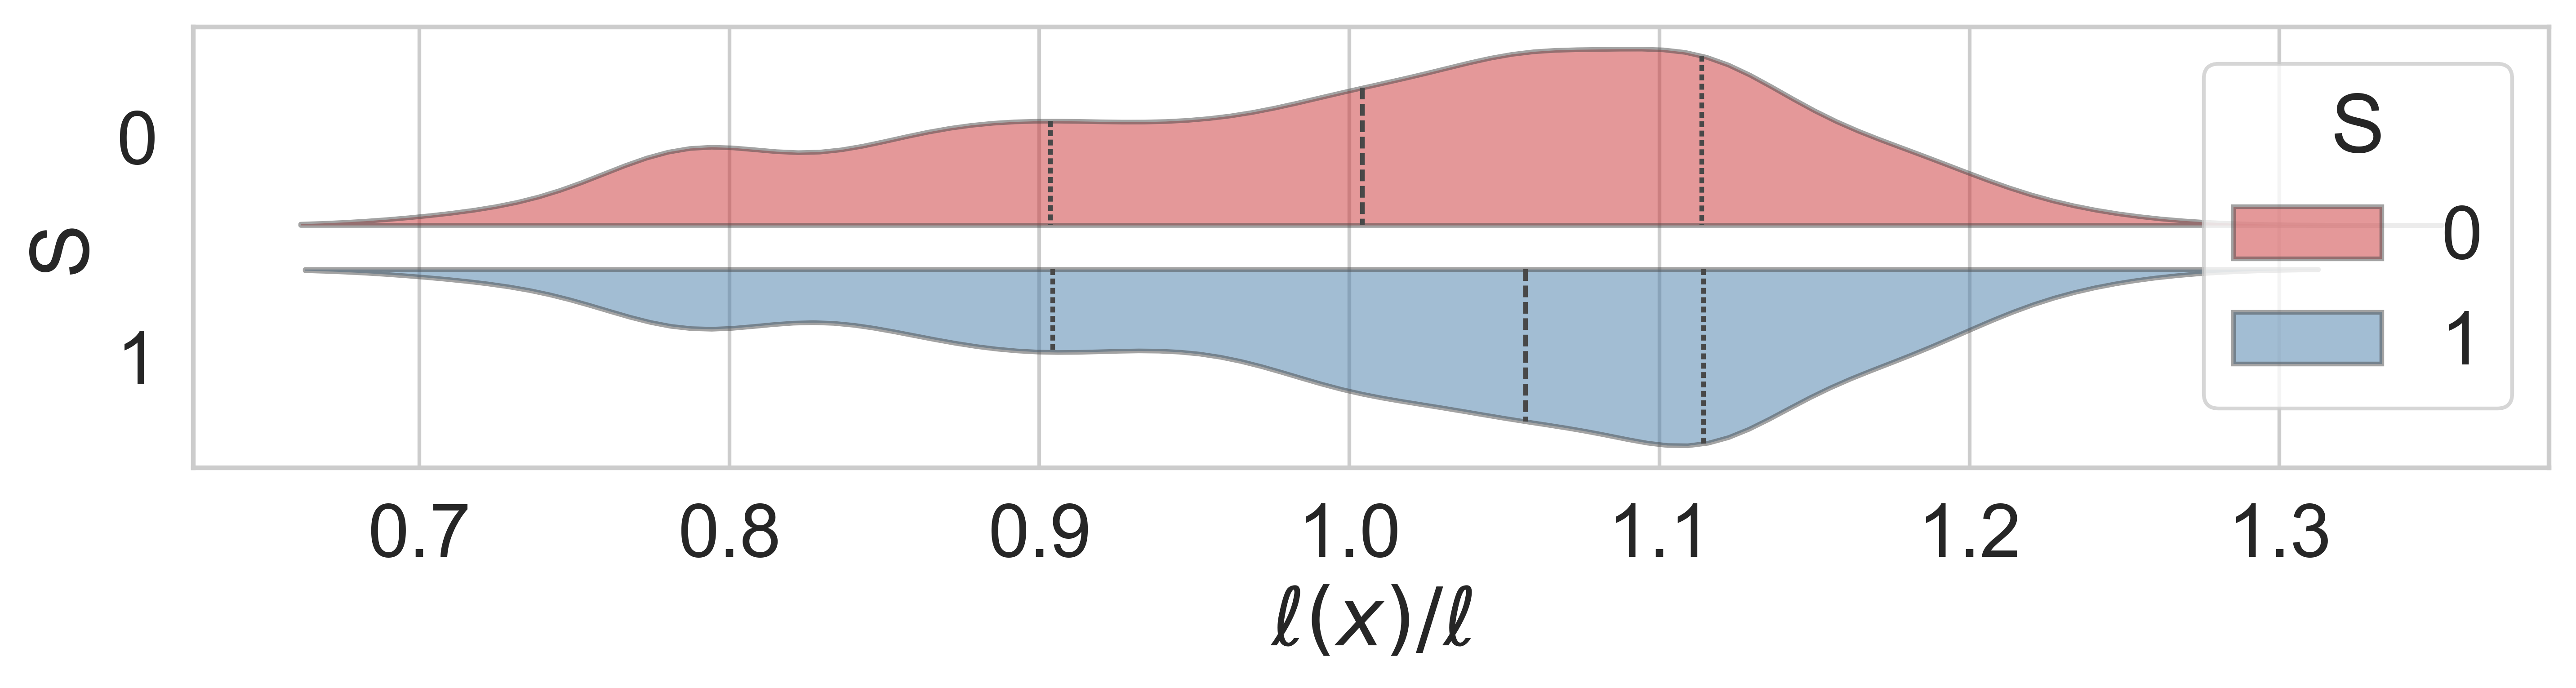

In [82]:
np.random.seed(42)
data_dummy_logit = data.copy(deep=True)
data_dummy_logit["pi(x)"] = pi_m_est.predict_proba(X_sim)[:, 1]
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.set(font_scale=1.8, style="whitegrid")
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="S",
    hue="S",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
    palette="Set1",
)
plt.xlabel(r"$\ell(x)/{\ell}$")
plt.tight_layout()

(1293, 10)
(-0.21285017700748124, 0.04556269599694969, -0.12717428896817146, 0.046532665543563785)
(-21.285017700748124, 4.550990657675282)


[Text(0.5769230769230769, 0.875, 'Age <= 56.0\ngini = 0.258\nsamples = 1293\nvalue = [197, 1096]'),
 Text(0.3076923076923077, 0.625, 'Other Race <= 0.5\ngini = 0.116\nsamples = 1162\nvalue = [72, 1090]'),
 Text(0.15384615384615385, 0.375, 'Age <= 39.5\ngini = 0.09\nsamples = 1098\nvalue = [52, 1046]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.039\nsamples = 814\nvalue = [16, 798]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.221\nsamples = 284\nvalue = [36, 248]'),
 Text(0.46153846153846156, 0.375, 'Age <= 29.5\ngini = 0.43\nsamples = 64\nvalue = [20, 44]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.469\nsamples = 32\nvalue = [20, 12]'),
 Text(0.8461538461538461, 0.625, 'Male <= 0.5\ngini = 0.087\nsamples = 131\nvalue = [125, 6]'),
 Text(0.7692307692307693, 0.375, 'IV Drug Use <= 0.5\ngini = 0.236\nsamples = 44\nvalue = [38, 6]'),
 Text(0.6923076923076923, 0.125, 'gini = 0.0\nsamples = 25\nvalue = [25,

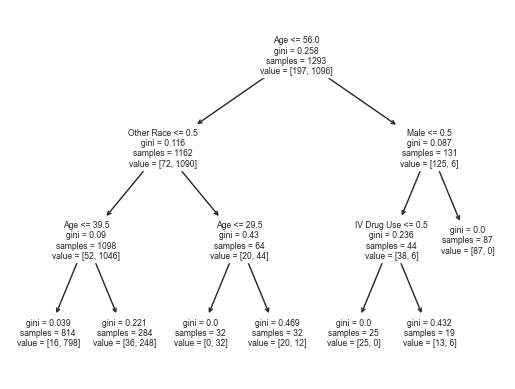

In [84]:
importlib.reload(learn)
np.random.seed(42)
D_brute, f_brute, _ = learn.kmeans_opt(
    data=data,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
)
print(
    (
        100 * D_brute.loc[D_brute["w"].astype(int) == 1]["v"].mean(),
        100 * D_brute.loc[D_brute["w"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_brute, feature_names=X_sim.columns)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.046543278061694775
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
(-12.717432526360394, 4.655083007126896)


[Text(0.5, 0.5, 'gini = 0.0\nsamples = 1293\nvalue = 1293.0')]

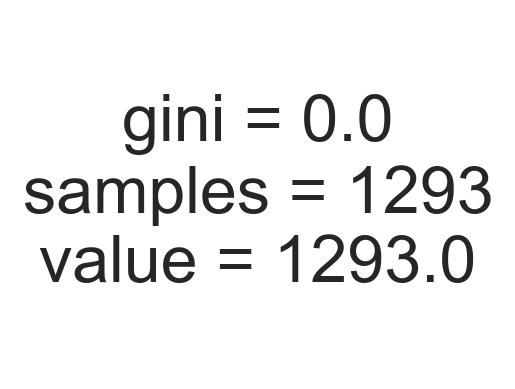

In [85]:
importlib.reload(learn)
np.random.seed(42)
D_linear, f_linear, _ = learn.linear_opt(
    data=data_dummy_logit,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
)
print(
    (
        100 * D_linear.loc[D_linear["w"].astype(int) == 1]["v"].mean(),
        100 * D_linear.loc[D_linear["w"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_linear, feature_names=X_sim.columns)

(-12.605573373934195, 4.657326284334759)


[Text(0.3333333333333333, 0.875, 'Hx Amphetamine <= 0.5\ngini = 0.002\nsamples = 1293\nvalue = [1, 1292]'),
 Text(0.16666666666666666, 0.625, 'gini = 0.0\nsamples = 1205\nvalue = [0, 1205]'),
 Text(0.5, 0.625, 'Black <= 0.5\ngini = 0.022\nsamples = 88\nvalue = [1, 87]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 86\nvalue = [0, 86]'),
 Text(0.6666666666666666, 0.375, 'IV Drug Use <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8333333333333334, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

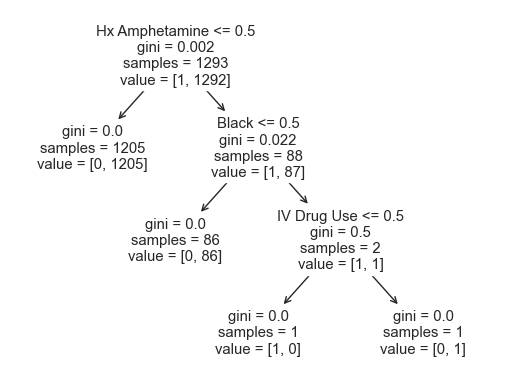

In [157]:
importlib.reload(learn)
np.random.seed(366)
D_tree, f_tree, _ = learn.tree_opt(
    data=data,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.1,
)
print(
    (
        100 * D_tree.loc[D_tree["w"].astype(int) == 1]["v"].mean(),
        100 * D_tree.loc[D_tree["w"].astype(int) == 1]["v"].sem(),
    )
)

tree.plot_tree(f_tree, feature_names=X_sim.columns)

In [152]:
[
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if i in list(local_obj.iloc[:10].index)
]

['w_tree_147',
 'w_tree_263',
 'w_tree_290',
 'w_tree_366',
 'w_tree_401',
 'w_tree_788',
 'w_tree_809',
 'w_tree_1579',
 'w_tree_1782',
 'w_tree_1977']

ATE Est: -0.1272
leaf              0.200000
Male              0.072904
Age               0.285708
Hx Cannabis       0.035007
IV Drug Use       0.072273
Hx Amphetamine    0.027706
Hx Benzo          0.056795
White             0.061411
Black             0.058277
Hispanic          0.071998
Other Race        0.057922
dtype: float64
(-16.209585982342816, 4.520109066405995)


[Text(0.5769230769230769, 0.875, 'Age <= 56.0\ngini = 0.204\nsamples = 1293\nvalue = [149, 1144]'),
 Text(0.3076923076923077, 0.625, 'Age <= 44.5\ngini = 0.044\nsamples = 1162\nvalue = [26, 1136]'),
 Text(0.15384615384615385, 0.375, 'Other Race <= 0.5\ngini = 0.014\nsamples = 962\nvalue = [7, 955]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.004\nsamples = 904\nvalue = [2, 902]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.158\nsamples = 58\nvalue = [5, 53]'),
 Text(0.46153846153846156, 0.375, 'Hispanic <= 0.5\ngini = 0.172\nsamples = 200\nvalue = [19, 181]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.093\nsamples = 164\nvalue = [8, 156]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.424\nsamples = 36\nvalue = [11, 25]'),
 Text(0.8461538461538461, 0.625, 'Male <= 0.5\ngini = 0.115\nsamples = 131\nvalue = [123, 8]'),
 Text(0.7692307692307693, 0.375, 'White <= 0.5\ngini = 0.298\nsamples = 44\nvalue = [36, 8]'),
 Text(0.6923076923076923, 0.125, 'gini = 0.0\nsamples = 26\nvalue = [26, 

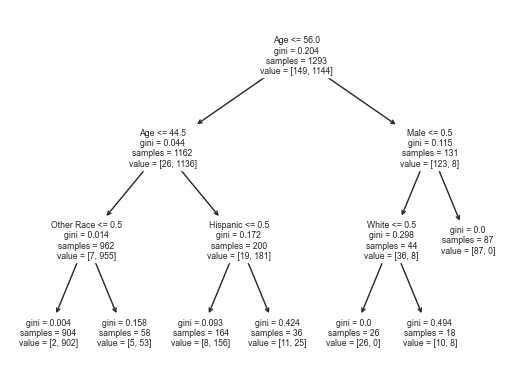

In [123]:
importlib.reload(learn)
np.random.seed(0)
D_rash, D_forest, w_forest, rashomon_set, f_forest, _ = learn.forest_opt(
    data=data,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    num_trees=2000,
    vote_threshold=99 / 100,
    explore_proba=0.1,
    feature_est="gbt",
    top_k_trees=1,
)
print(
    (
        100 * D_rash.loc[D_rash["w_opt"].astype(int) == 1]["v"].mean(),
        100 * D_rash.loc[D_rash["w_opt"].astype(int) == 1]["v"].sem(),
    )
)

# tree.plot_tree(f_forest, feature_names=X_sim.columns)

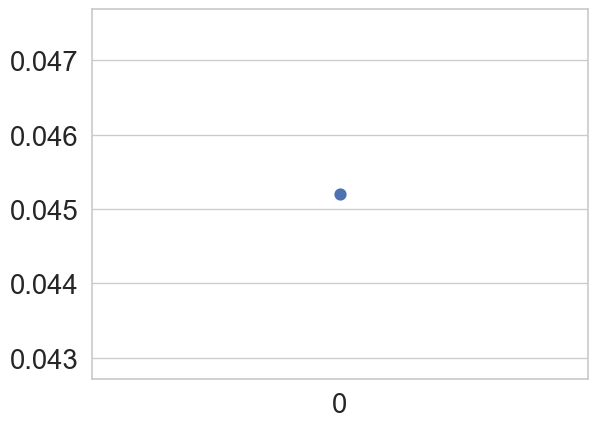

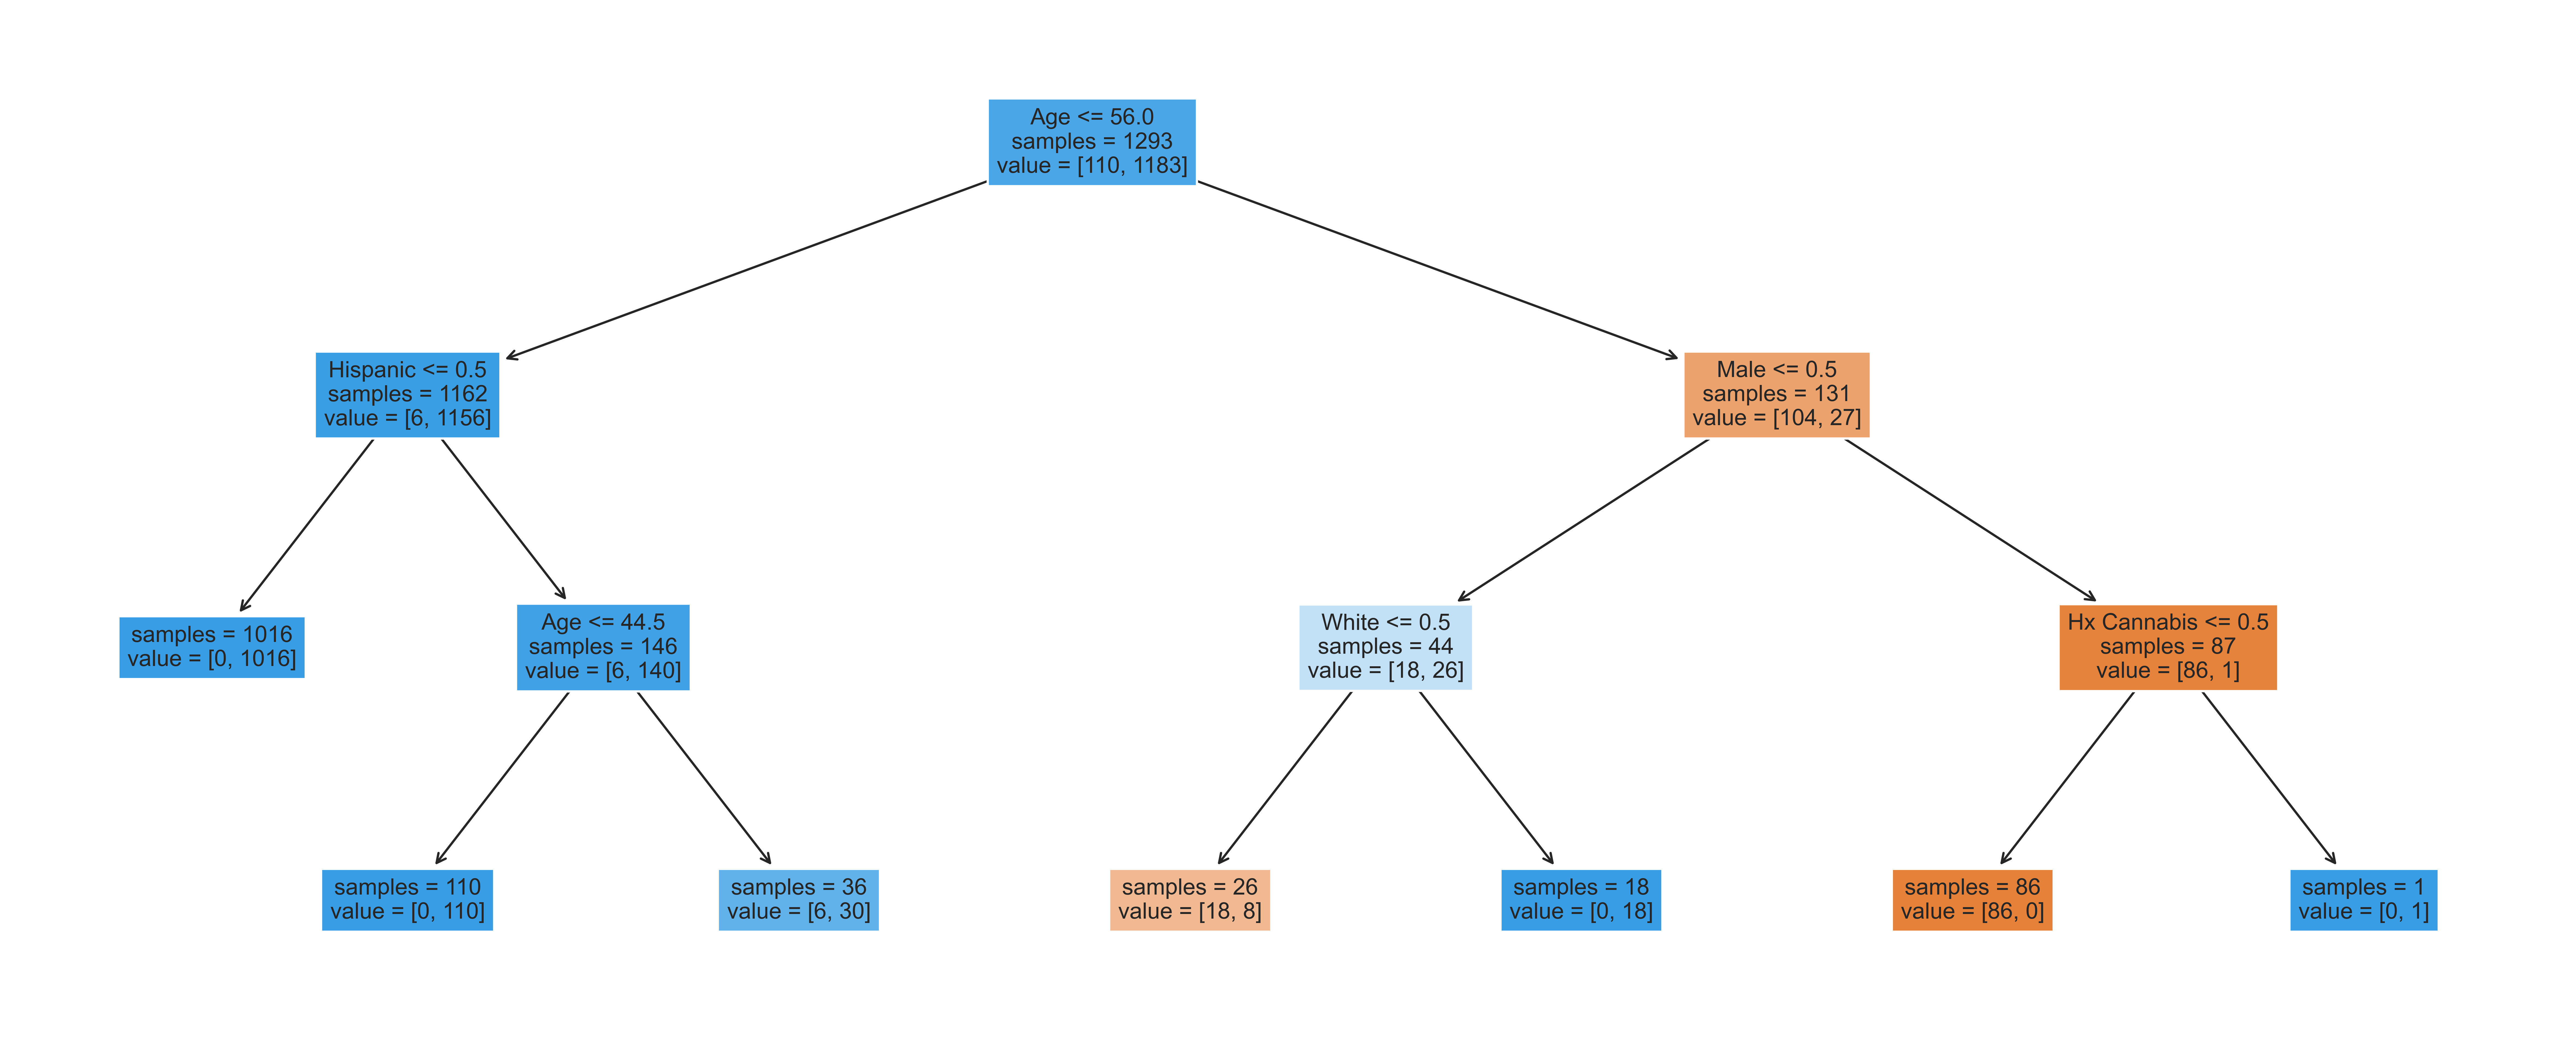

In [135]:
baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
local_obj = pd.DataFrame(
    np.array([w_forest[i]["local objective"] for i in range(len(w_forest))]),
    columns=["Objective"],
).sort_values(by="Objective")

top_k = 1
sns.pointplot((local_obj.iloc[:top_k])["Objective"].values)


w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if i in list(local_obj.iloc[:top_k].index)
]
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.99).astype(int)
D_rash["w_opt"] = avg_votes

np.random.seed(42)
num_trees = 1
explainer = tree.DecisionTreeClassifier(max_depth=3).fit(
    X.loc[avg_votes.index], avg_votes
)


fig, ax = plt.subplots(nrows=num_trees, figsize=(20, 8), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            # proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            # proportion=True,
        )

<Axes: >

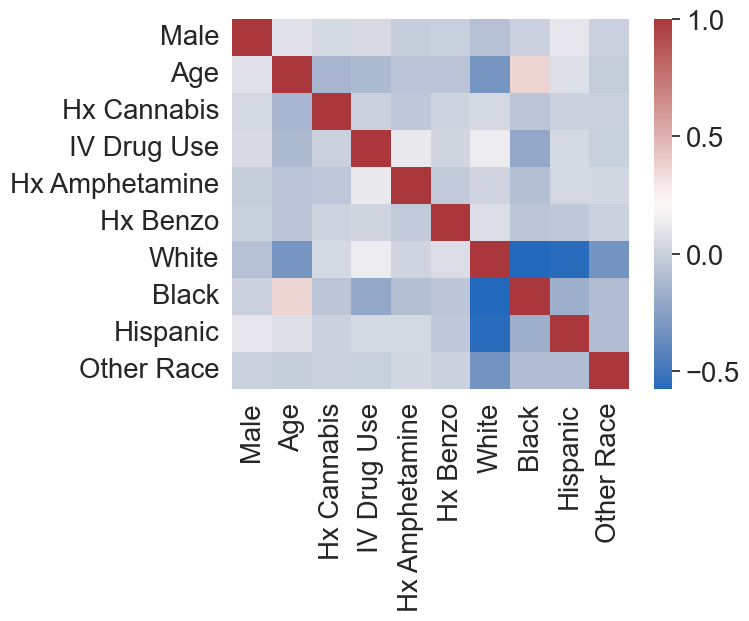

In [136]:
sns.heatmap(X.corr(), cmap="vlag")

In [115]:
joint_sim["TE"] = joint_sim["Y(1)"] - joint_sim["Y(0)"]
joint_sim["h"] = (joint_sim["TE"] - joint_sim["TE"].mean()) ** 2

In [116]:
te_exp = en.GradientBoostingRegressor().fit(X_sim, joint_sim["h"])

In [119]:
feature_imp["treatment effect"] = pd.Series(
    te_exp.feature_importances_, index=X_sim.columns
).abs()

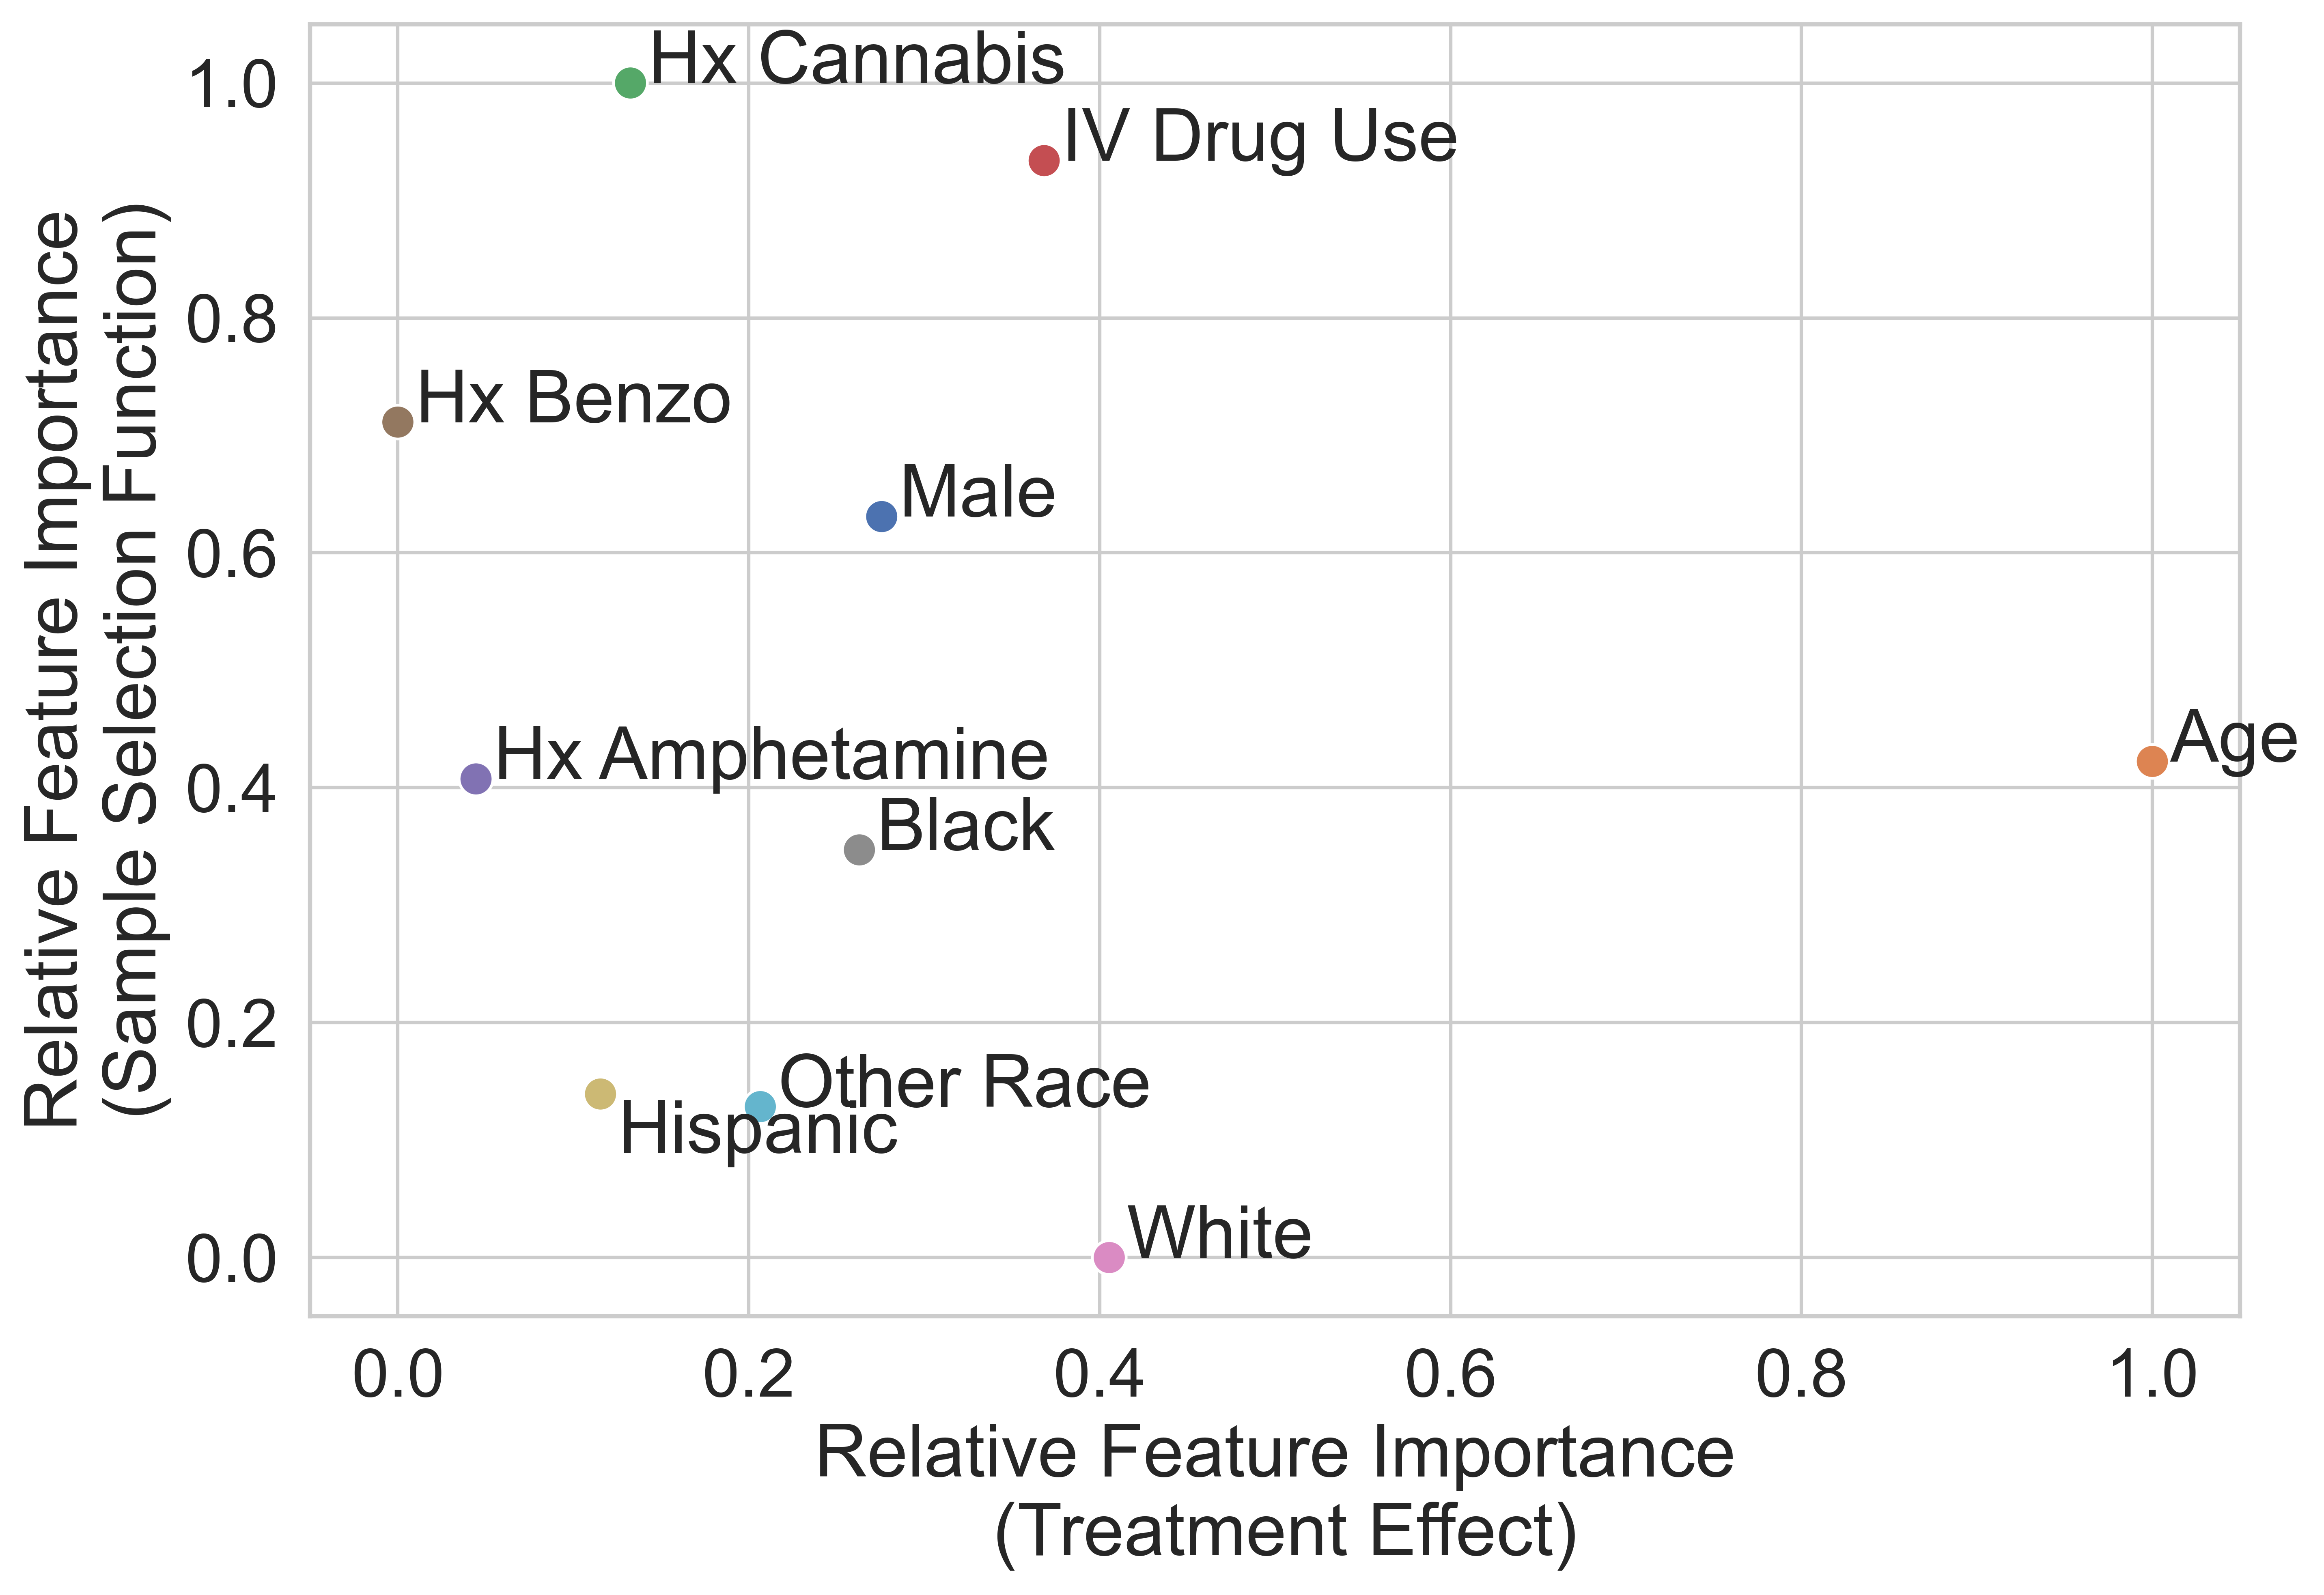

In [146]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_imp_scaled = pd.DataFrame(
    scaler.fit_transform(feature_imp),
    columns=feature_imp.columns,
    index=feature_imp.index,
)


def label_point(data, x, y, val, ax):
    for i in data.index:
        if "Hispanic" in str(data.loc[i][val]):
            ax.text(data.loc[i][x] + 0.01, data.loc[i][y] - 0.05, str(data.loc[i][val]))
        else:
            ax.text(data.loc[i][x] + 0.01, data.loc[i][y], str(data.loc[i][val]))


fig, ax = plt.subplots(figsize=(10, 7), dpi=600)
sns.scatterplot(
    data=np.log2(feature_imp_scaled + 1).reset_index(),
    x="treatment effect",
    y="sample",
    hue="index",
    ax=ax,
    s=100,
    legend=False,
)
label_point(
    data=np.log2(feature_imp_scaled + 1).reset_index(),
    x="treatment effect",
    y="sample",
    val="index",
    ax=ax,
)
plt.xlabel("Relative Feature Importance\n (Treatment Effect)")
plt.ylabel("Relative Feature Importance\n (Sample Selection Function)")
# plt.legend(ncols=3, loc=(0, -0.35))
plt.tight_layout()
plt.savefig("feature_importance_synth_case.pdf")